# MED 7 Machine leaning mini project
*Sebastian Whitehead 20204568*
*MED 7 2023*


### Table of content:
---
1. [Data dowloading and importing](#item-one)
2. [Preliminary data plotting](#item-two)
3. [Test & training set creation](#item-three)
4. [Data investigation and discovery](#item-four)
---

<a id="item-one"></a>
## Data downloading and importing
The following code downloads a fresh copy of the data from the provided URL and extracts this data to a sub directory of the project folder.

In [7]:
import os
import urllib.request
import zipfile
import shutil

url = "https://archive.ics.uci.edu/static/public/864/room+occupancy+estimation.zip"
folder = "data"

#If folder already exists remove
if os.path.exists(folder):
    shutil.rmtree(folder)
    
os.makedirs(folder) # create data directory

compressedFile, _ = urllib.request.urlretrieve(url) # Get the zip file from the data url

with zipfile.ZipFile(compressedFile, 'r') as zip: # Extract the zipfile to the data folder
    zip.extractall(folder)
    
 # Delete the zipfile that was downloaded
os.remove(compressedFile)

Read the now dowloaded CSV file with the padas package and describe the data using the same package

In [94]:
import pandas as pd
from pathlib import Path

# Import the CSV file
csv_file = Path("data/Occupancy_Estimation.csv")
df = pd.read_csv(csv_file)

# Print the DataFrame

df.head()
#print(df.info())
#df.describe()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


---
<a id="item-two"></a>
## Preliminary plotting of data
The following code uses matplotlib to plot the data in histogram format. This is done as a means to create a better understanding of the datas distrobution and scale, and will be used for considerations into what sort of transformations that will likly have to to the different sensor values.

In [45]:
# extra code – code to save the figures as high-res PNGs for the book

IMAGES_PATH = Path() / "images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

<function matplotlib.pyplot.show(close=None, block=None)>

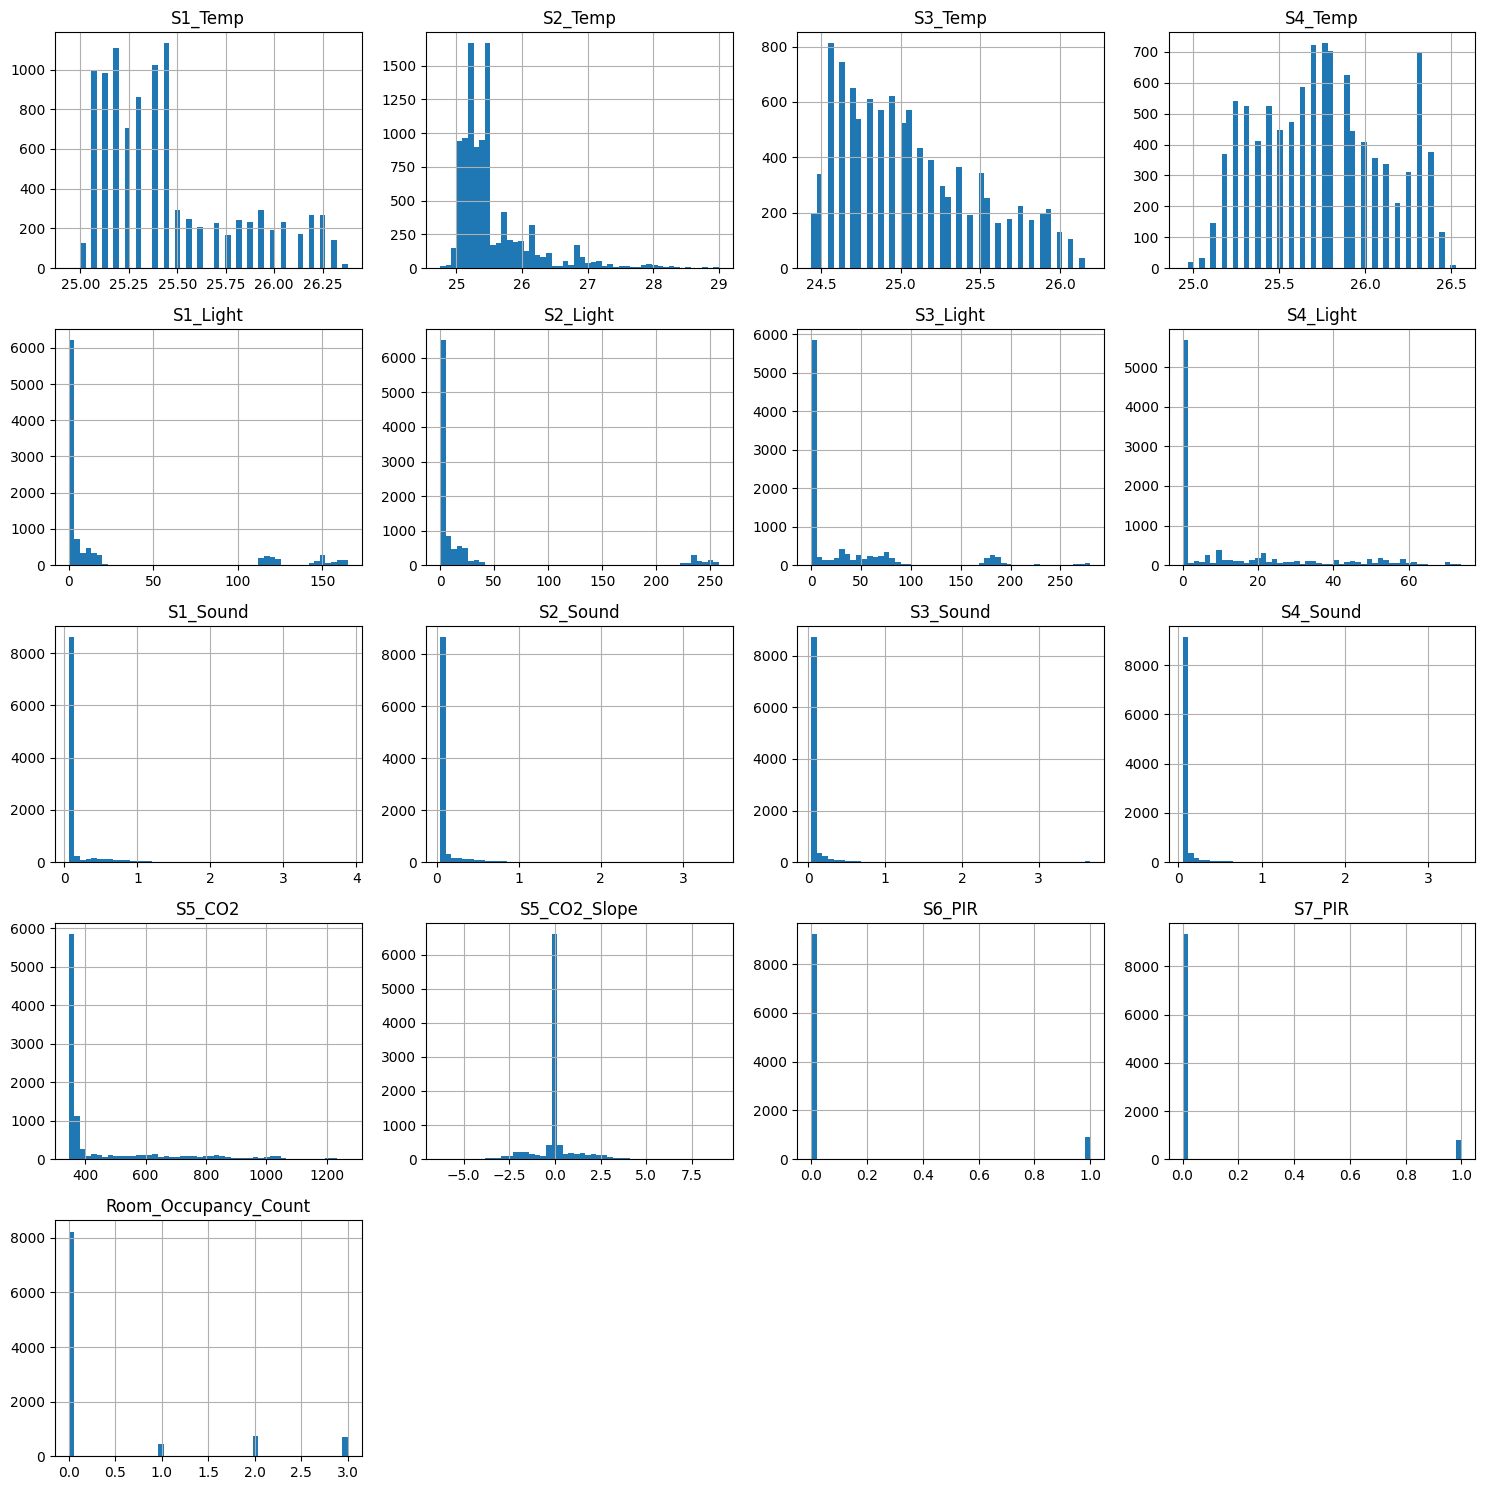

In [46]:
import matplotlib.pyplot as plt

plt.rc('font', size=10)
plt.rc('axes', labelsize=10, titlesize=12)
plt.rc('legend', fontsize=7)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=50, figsize=(15, 15))
save_fig("attribute_hisogram_plots")
plt.show


---
<a id="item-three"></a>
## Test & Training data set creation

In [22]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

*Fixed seed value generated by random.org*

In [ ]:
np.random.seed(316)
train_set, test_set = shuffle_and_split_data(df, 0.2)

In [36]:
train_set, test_set = shuffle_and_split_data(df, 0.2)

print(f'Test set length:  {len(test_set)}  , Training set length: {len(train_set)}')
print(f'Actual percentage = {len(test_set) / (len(train_set) + len(test_set)) * 100 }%')

Test set length:  2025  , Training set length: 8104
Actual percentage = 19.992101885674796%


### Alternative Method using sklearn


In [90]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=316)

print(f'Test set length:  {len(test_set)}  , Training set length: {len(train_set)}')
print(f'Actual percentage = {len(test_set) / (len(train_set) + len(test_set)) * 100 }%')

Test set length:  2026  , Training set length: 8103
Actual percentage = 20.0019745285813%


<a id="item-four"></a>
## Data discovery


#### Looking for correlations

In [95]:
# Creates 3 New colums which average All 3 Temp, Light and sound sensors
df['average_Temp'] = df[['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp' ]].mean(axis=1)
df['average_Light'] = df[['S1_Light', 'S2_Light', 'S3_Light', 'S4_Light']].mean(axis=1)
df['average_Sound'] = df[['S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound']].mean(axis=1)
df['OR_PIR'] = df[['S6_PIR', 'S7_PIR']].max(axis=1)
df['AND_PIR'] = df[['S6_PIR', 'S7_PIR']].min(axis=1)

In [96]:
df['Date'] = pd.to_datetime(df['Date'])         # Format the date string to a valid date value with pandas
df['Day_of_week'] = df['Date'].dt.day_name()    # Add a string value for the given day of the week
df['Day_of_week_int'] = df['Date'].dt.dayofweek # Create a column representing the day of the week with Monday as 0 and Sunday as 7

In [97]:
# Creates a corrilation matrix currently ignoring currently unprocessable columns
selected_columns = [col for col in df.columns if col not in ['Day_of_week', 'Time']]
corr_matrix = df[selected_columns].corr()
corr_matrix["Room_Occupancy_Count"].sort_values(ascending=False)

Room_Occupancy_Count    1.000000
average_Light           0.854160
S1_Light                0.849058
S3_Light                0.793081
S2_Light                0.788764
OR_PIR                  0.767223
S1_Temp                 0.700868
S7_PIR                  0.695138
average_Temp            0.692698
S2_Temp                 0.671263
S5_CO2                  0.660144
average_Sound           0.653527
S3_Temp                 0.652047
S6_PIR                  0.633133
S5_CO2_Slope            0.601105
S1_Sound                0.573748
S2_Sound                0.557853
AND_PIR                 0.550874
S3_Sound                0.531685
S4_Temp                 0.526509
S4_Sound                0.460287
S4_Light                0.355715
Day_of_week_int         0.168623
Date                   -0.079153
Name: Room_Occupancy_Count, dtype: float64

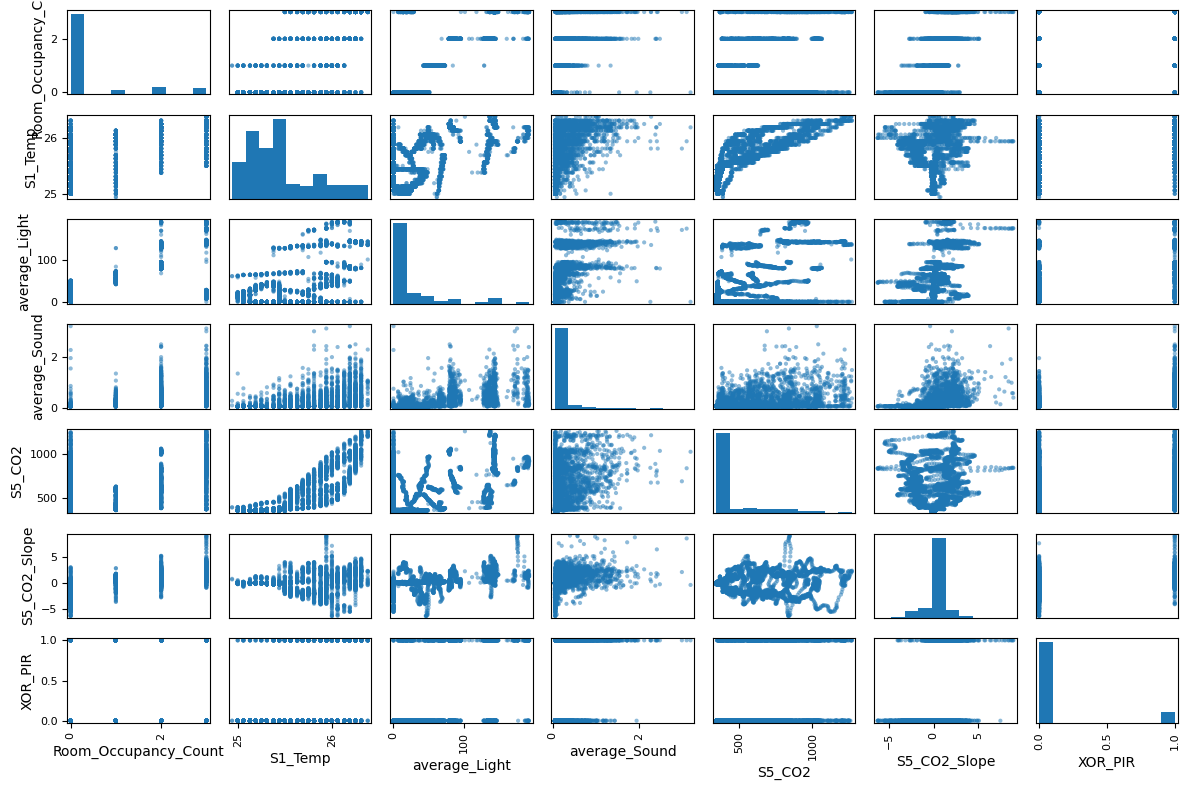

In [86]:
from pandas.plotting import scatter_matrix

attributes = ["Room_Occupancy_Count", "S1_Temp", "average_Light", "average_Sound",
              "S5_CO2", "S5_CO2_Slope", 'XOR_PIR']
scatter_matrix(df[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")  # extra code
plt.show()

## Prepping data for Machine leaning